## Auto reload

In [1]:
%load_ext autoreload
%autoreload 2

## LIB

In [4]:
%reload_ext autoreload

# Basic lib
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# config
import yaml

# Custom lib
from src.loader import Loader
from src.loan_preprocessor import Loan_Preprocessor
from src.log_preprocessor import Log_Preprocessor
from src.user_preprocessor import User_Preprocessor
from src.cofix_preprocessor import Cofix_Preprocessor
from src.matcher import Matcher
from src.sampling import down_sampling, check_imbalanced_label, split_train_valid
from src.mice import mice
from src.bank import Bank_info
from src.clustering import Clustering, GowerDistance, KPrototype
from src.clustering_preprocessor import ClusteringPreprocessor
from src.statistic_check import TTEST,ANOVA
from sklearn.preprocessing import MinMaxScaler
from src.eda import EDA, EDAPreprocessing

# ignore warnings
pd.set_option('mode.chained_assignment',  None)
plt.style.use('ggplot')

## Load Config

In [8]:
with open("config.yaml", 'r') as config_file:
    config_dict = yaml.load(config_file, Loader=yaml.FullLoader)

## Load Data

In [9]:
loader_config = config_dict.get('Loader')

In [11]:
loader_config = config_dict.get('Loader')
loader = Loader(loader_config)
loan_df = loader.run('loan_result.csv')
log_df = loader.run('log_data.csv')
user_df = loader.run('user_spec.csv')
cofix_df = loader.run('cofix.csv')

# EDA

In [12]:
## diet
loan_trainer = EDAPreprocessing(loan_df)
log_trainer = EDAPreprocessing(log_df)
user_trainer = EDAPreprocessing(user_df)

loan = loan_trainer.diet_dataframe()
log = log_trainer.diet_dataframe()
user = user_trainer.diet_dataframe()

diet_dataframe 함수의 소요시간
: 8.59초
diet_dataframe 함수의 소요시간
: 12.62초
diet_dataframe 함수의 소요시간
: 2.62초


## Loan EDA

Checking Distributions...


7it [11:58, 102.64s/it]



Done!


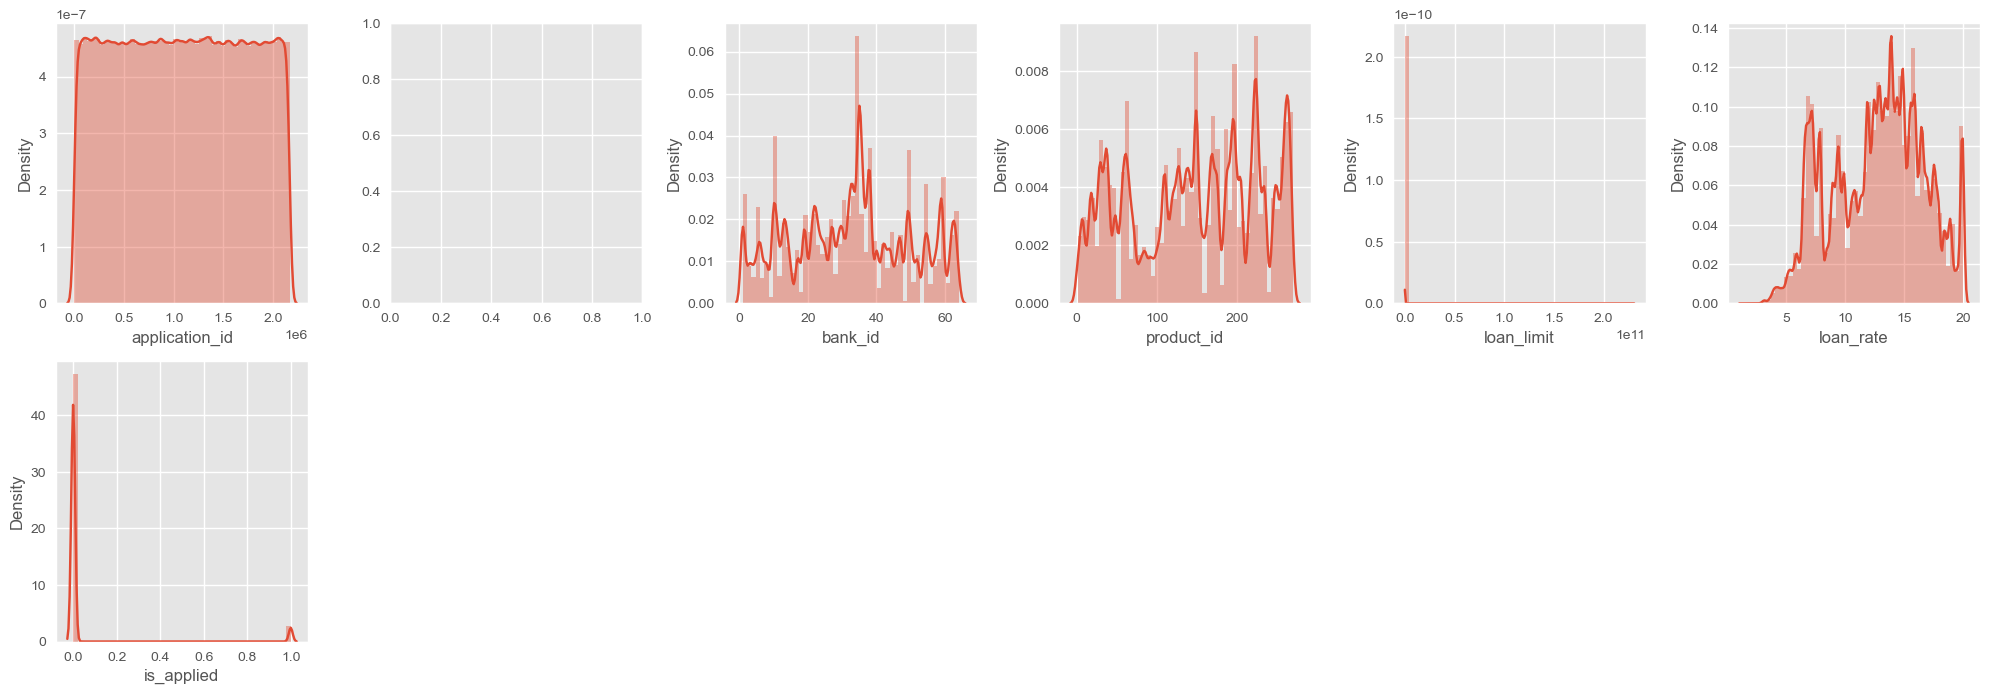

In [13]:
loan_eda = EDA(loan, 'loan_result')
loan_eda.check_distributions()

변수간 상관 관계를 확인합니다...
Done!!


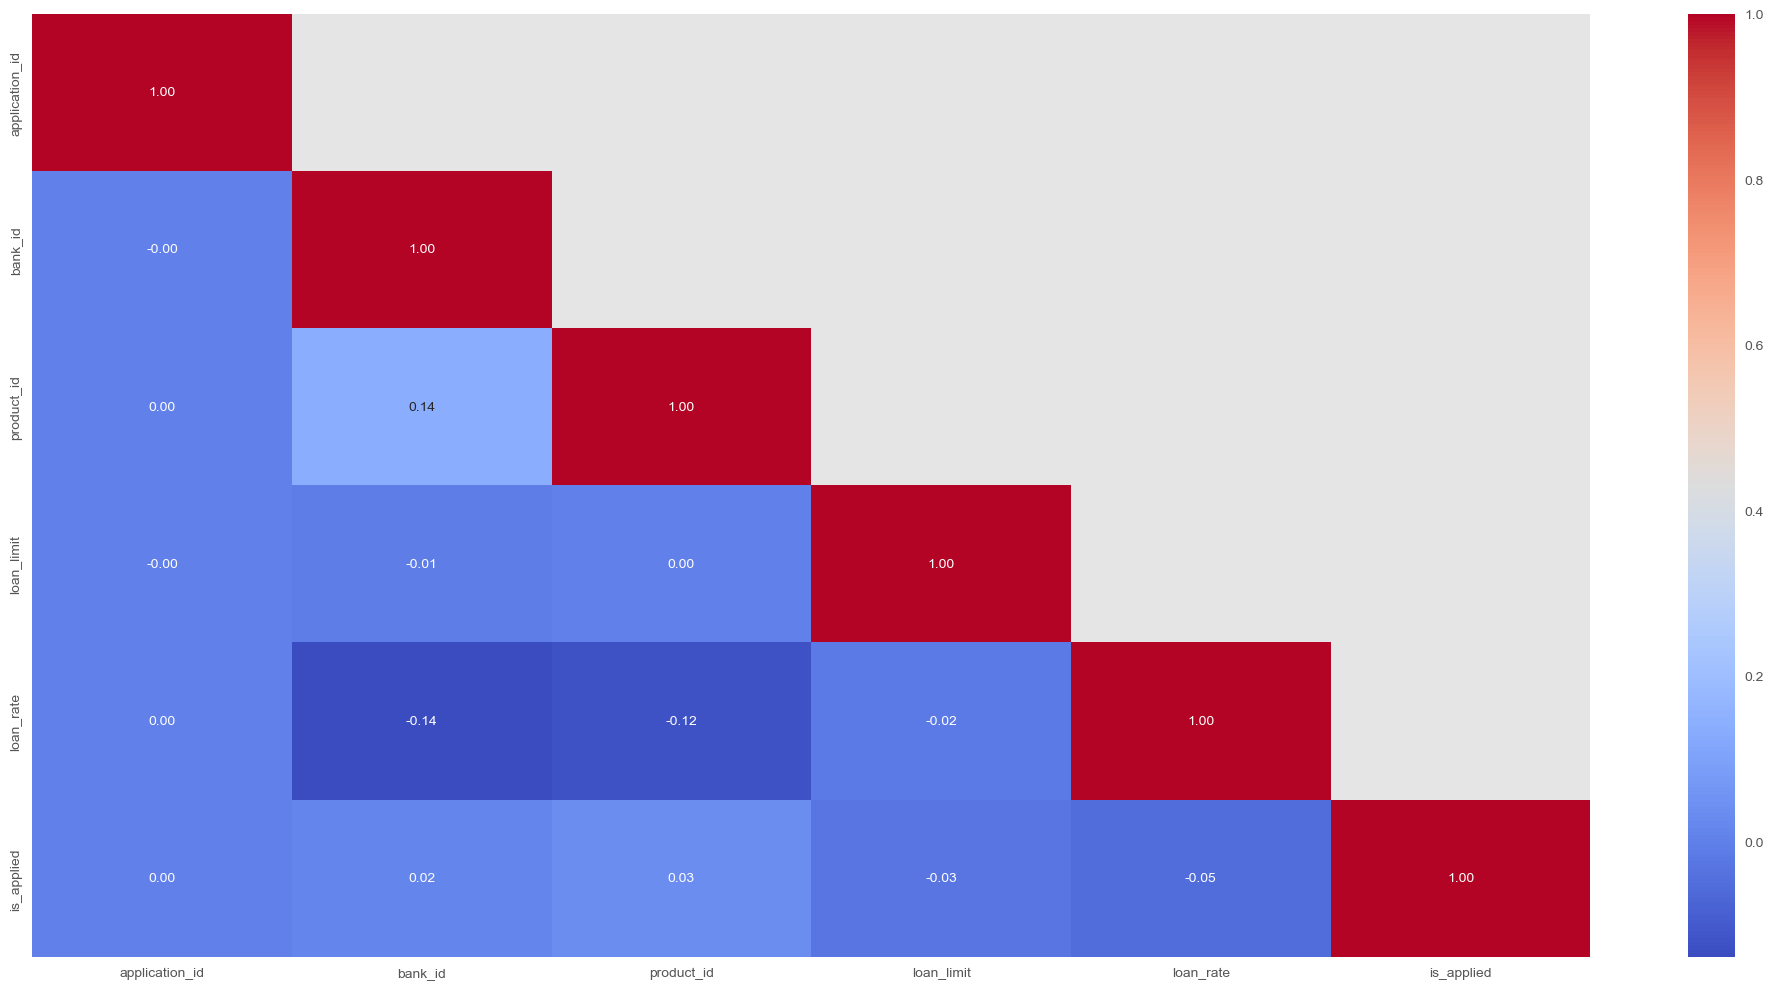

In [14]:
loan_eda.check_corr()

결측치를 확인합니다...
👀칼럼 별 결측치 수
	 ❗ application_id : 0
	 ❗ loanapply_insert_time : 0
	 ❗ bank_id : 0
	 ❗ product_id : 0
	 ❗ loan_limit : 7495
	 ❗ loan_rate : 7495
	 ❗ is_applied : 3257239
Done!!


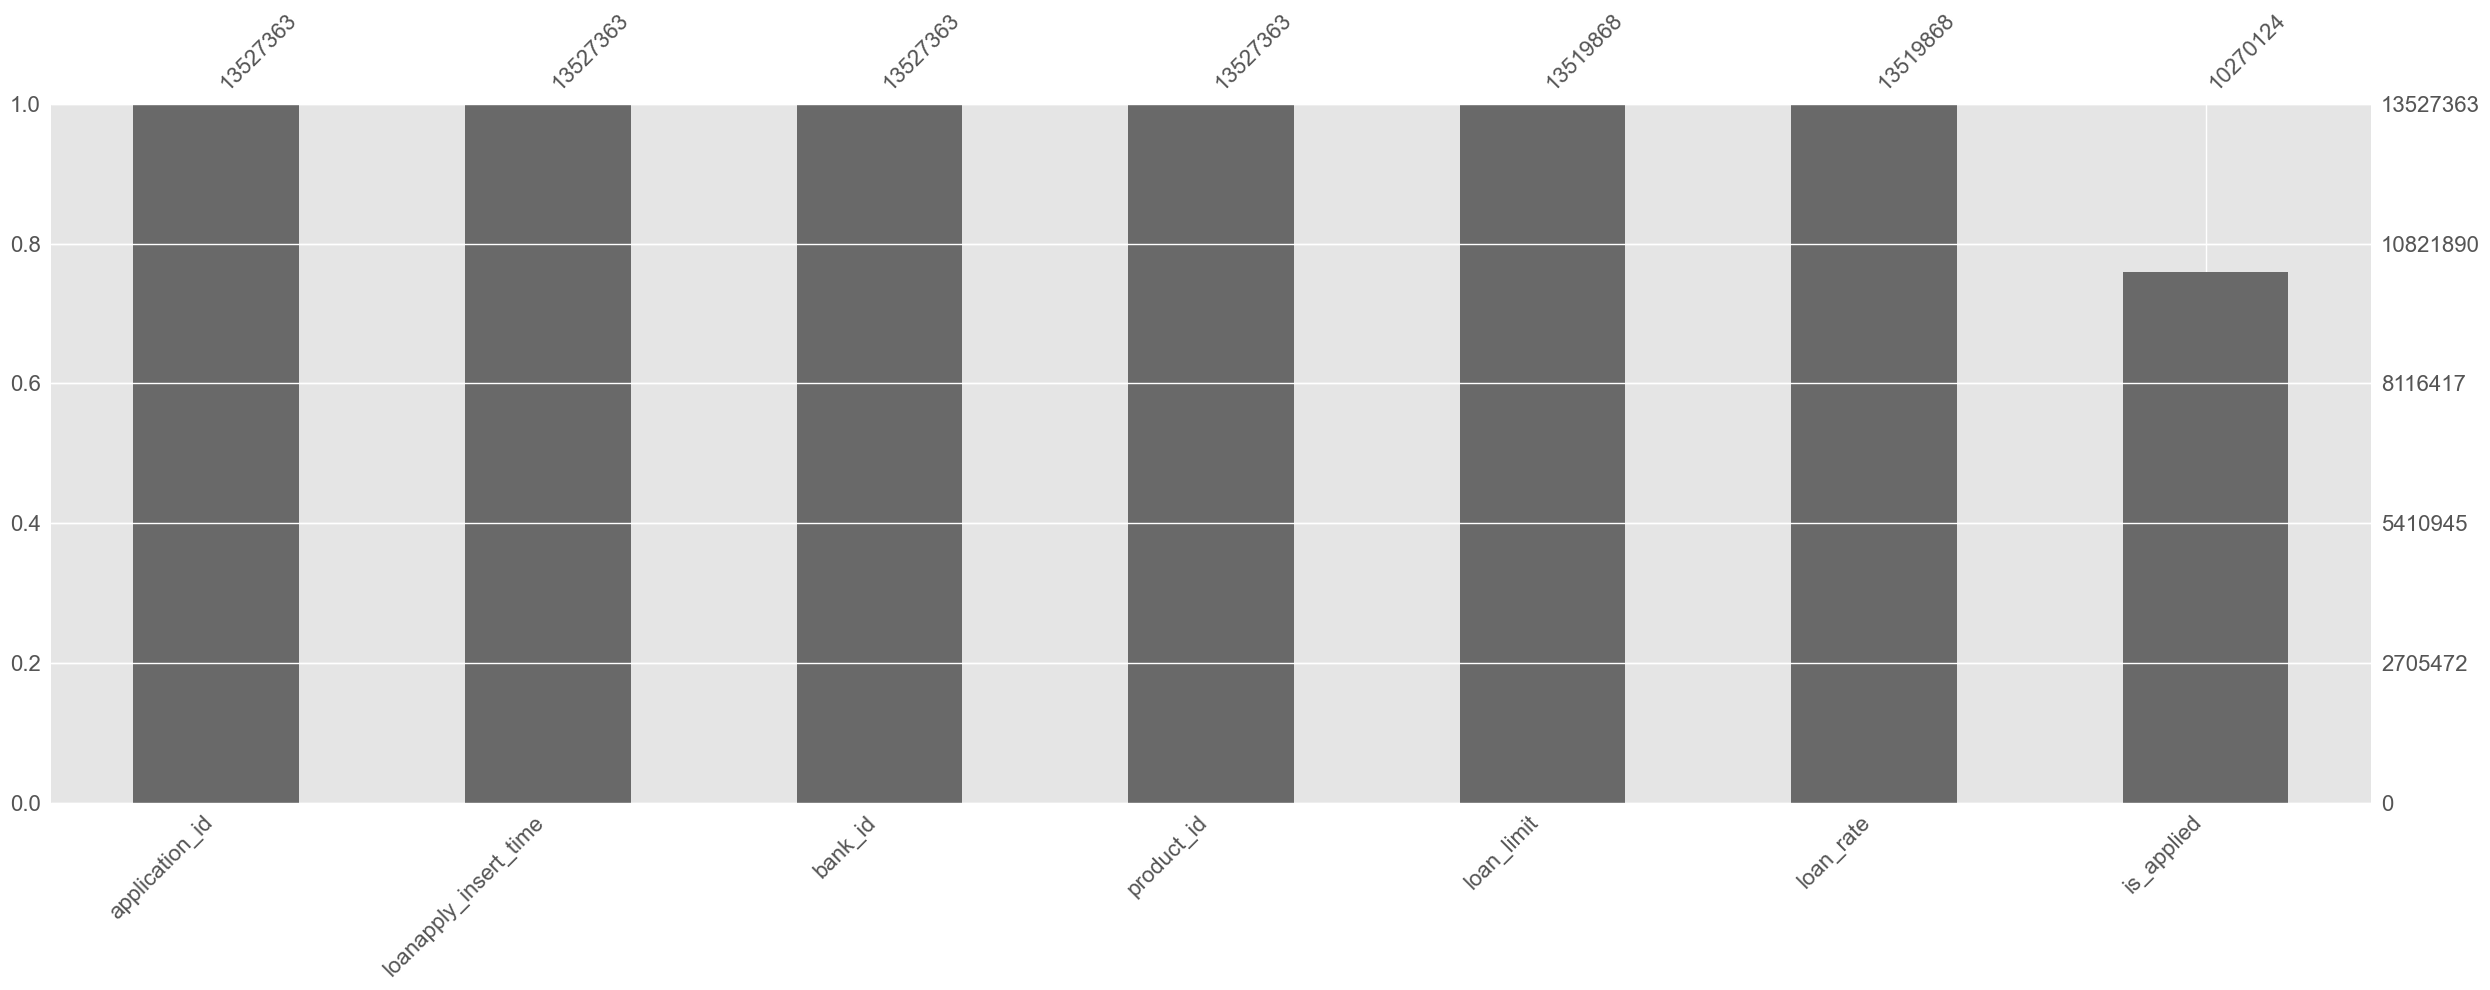

In [15]:
loan_eda.check_missing_values()

이상치를 확인합니다...
파악된 연속형 변수
 ['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied']
Done!!


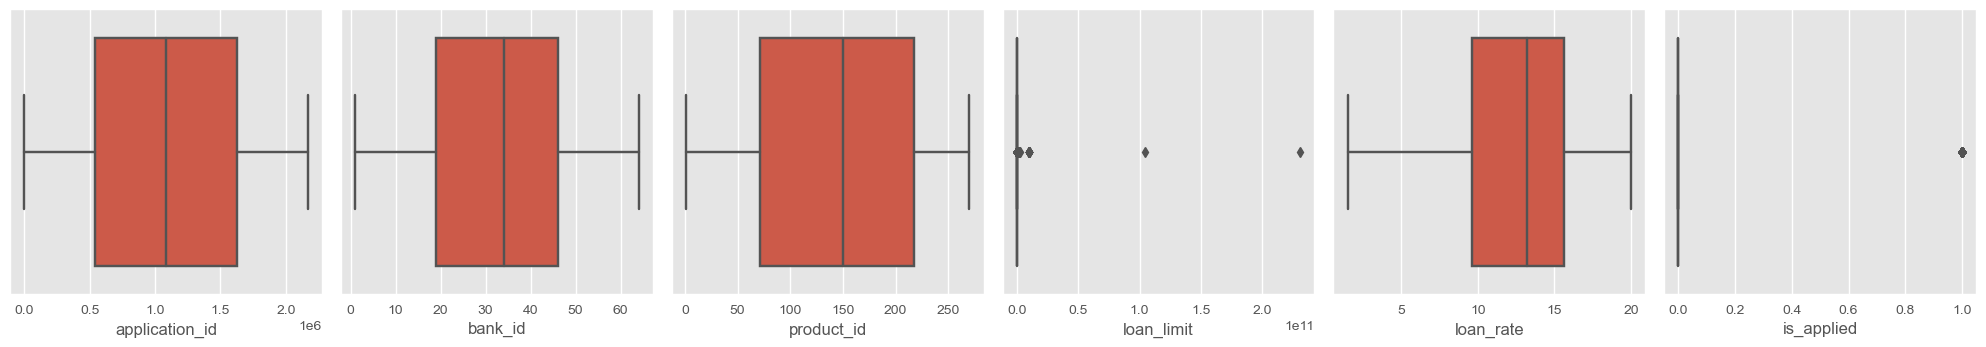

In [16]:
loan_eda.check_outliers()

## Log EDA

Checking Distributions...


6it [02:08, 21.40s/it] 

mp_app_version 칼럼은 너무 많은 범주를 가지고 있습니다. 다른 전처리를 추천드립니다.

Done!


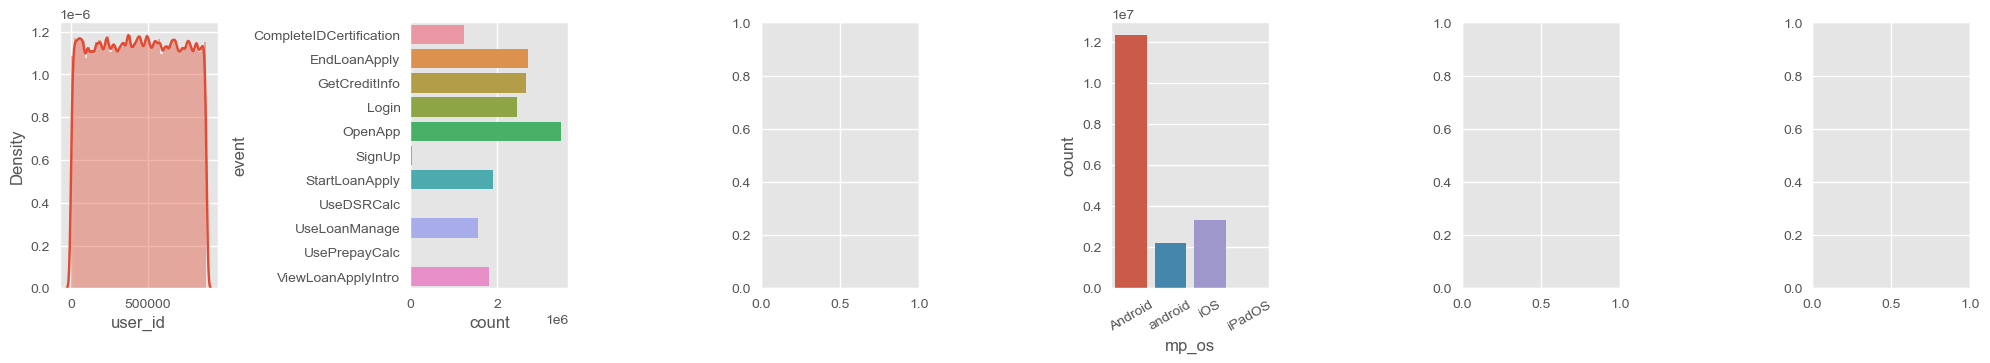

In [17]:
log_eda = EDA(log, 'log_data')
log_eda.check_distributions()

In [18]:
# log_eda.check_corr()

결측치를 확인합니다...
👀칼럼 별 결측치 수
	 ❗ user_id : 0
	 ❗ event : 0
	 ❗ timestamp : 0
	 ❗ mp_os : 980
	 ❗ mp_app_version : 660597
	 ❗ date_cd : 0
Done!!


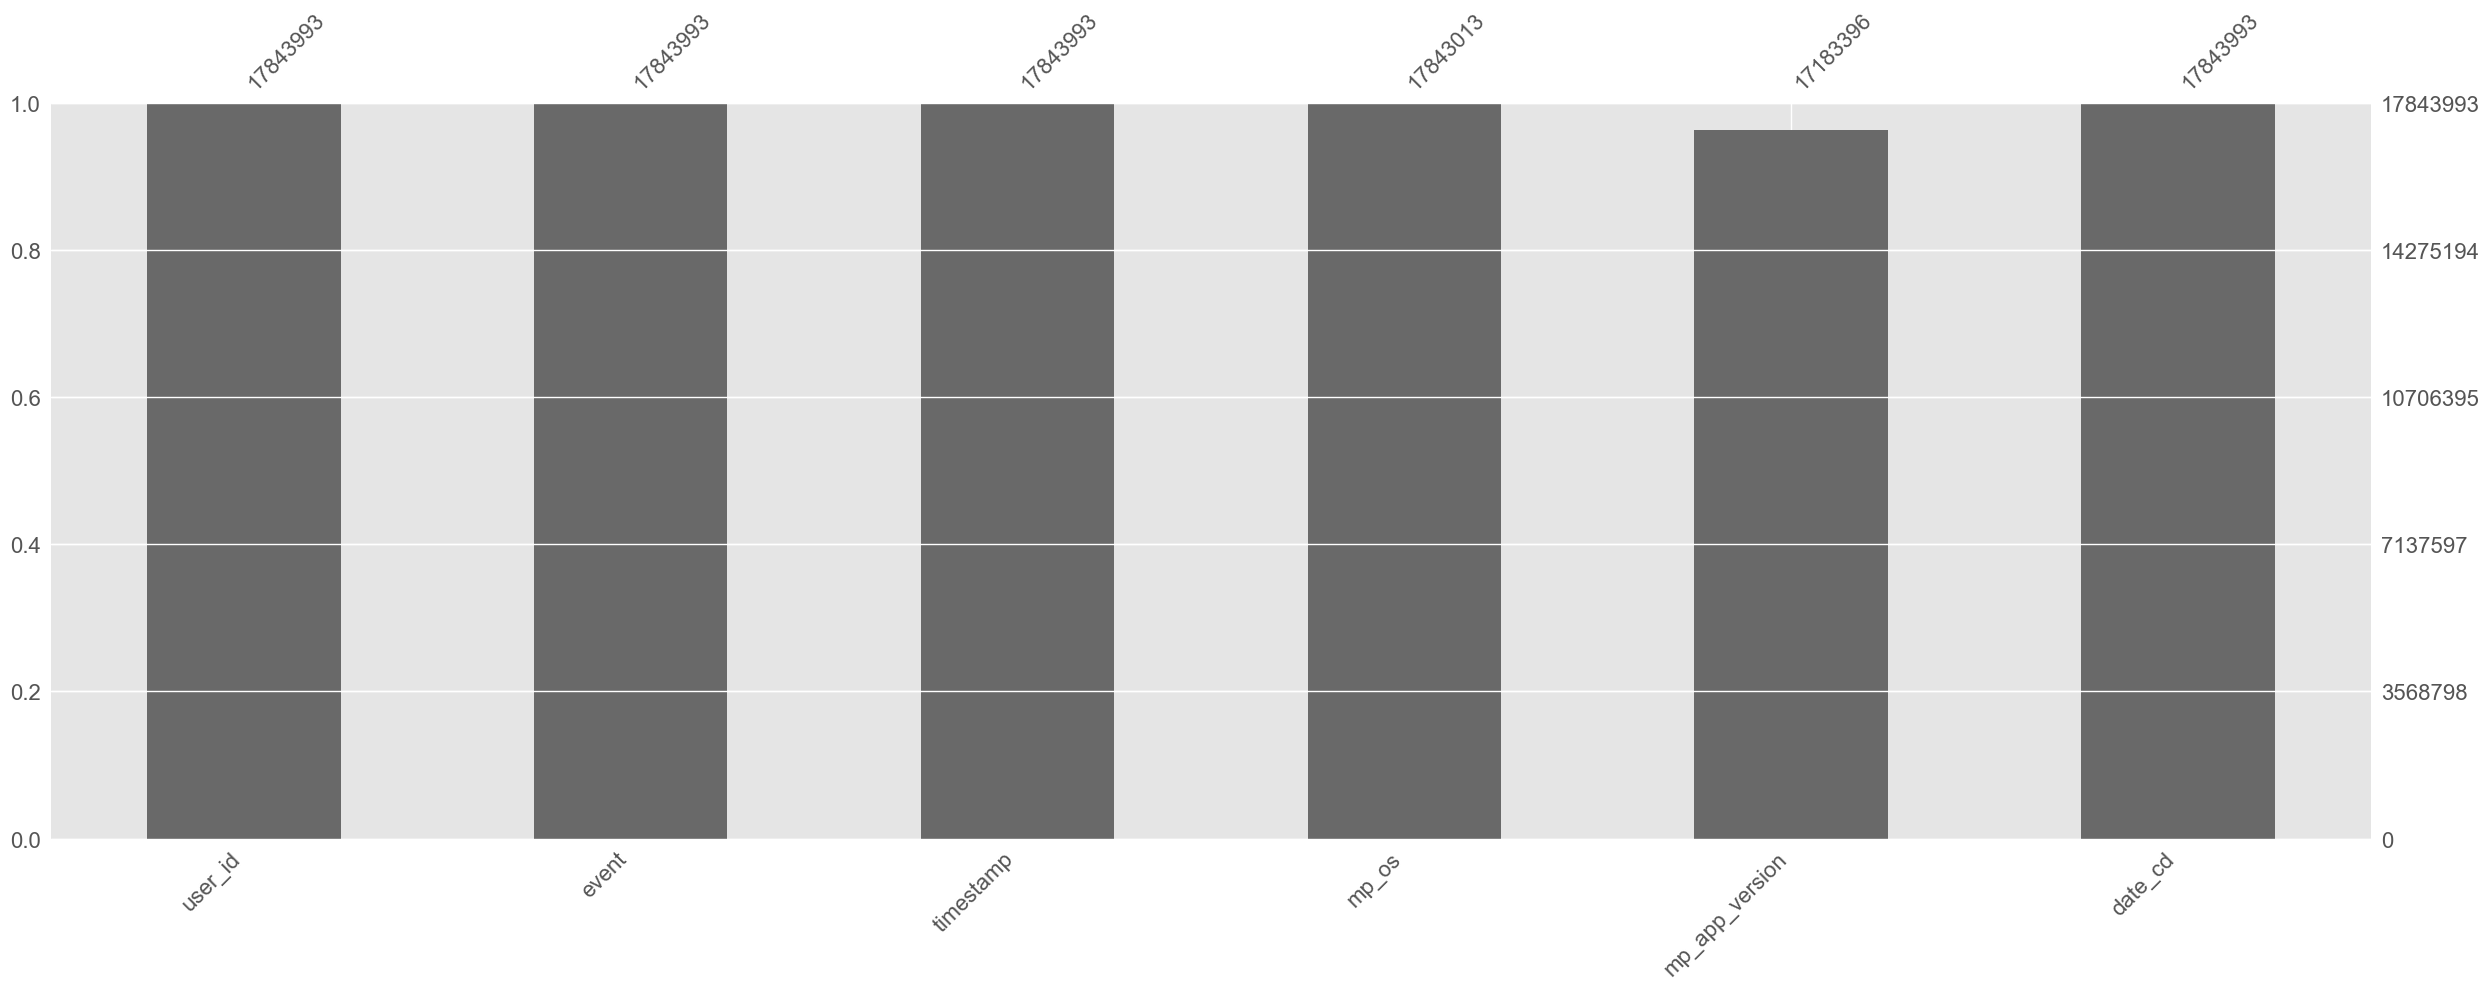

In [19]:
log_eda.check_missing_values()

이상치를 확인합니다...
파악된 연속형 변수
 ['user_id']
Done!!


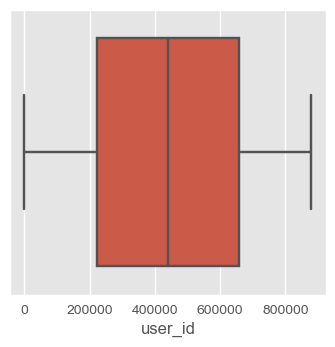

In [20]:
log_eda.check_outliers()

## User EDA

Checking Distributions...


17it [01:48,  6.41s/it]



Done!


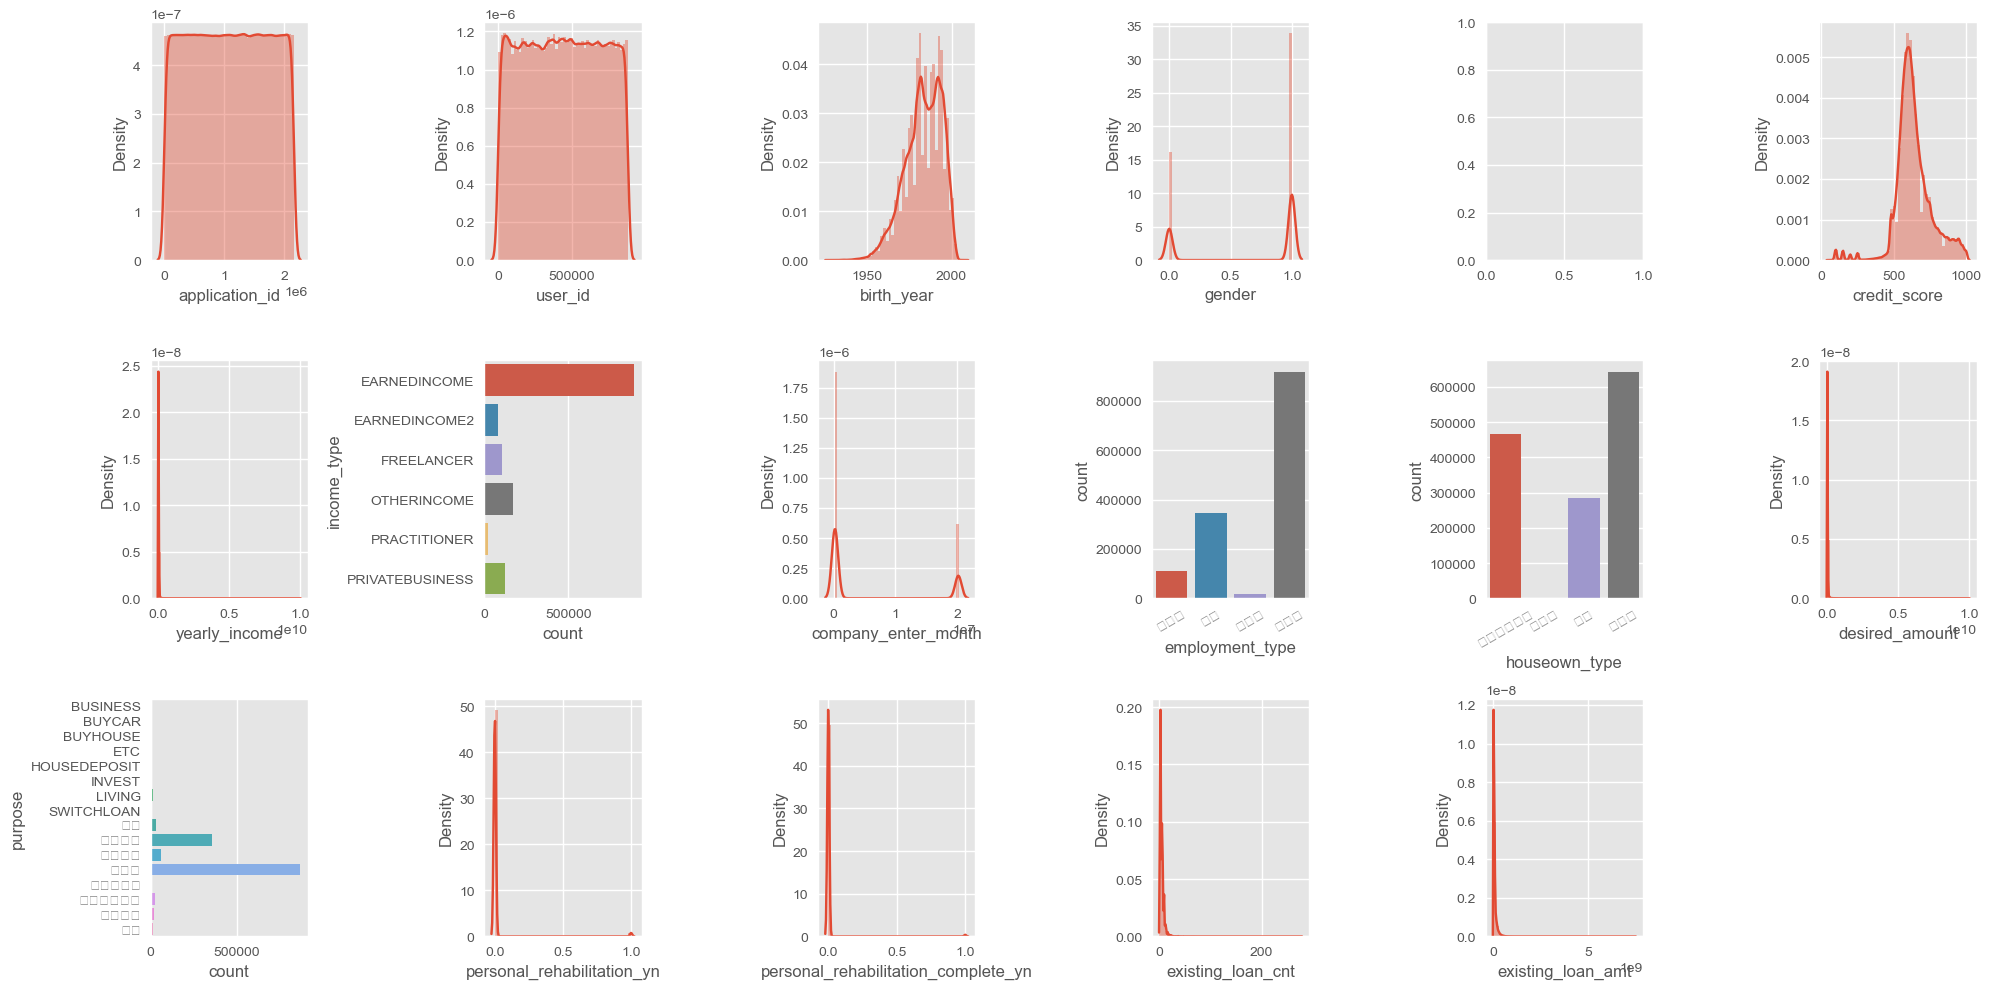

In [21]:
user_eda = EDA(user, 'user_spec')
user_eda.check_distributions()

변수간 상관 관계를 확인합니다...
Done!!


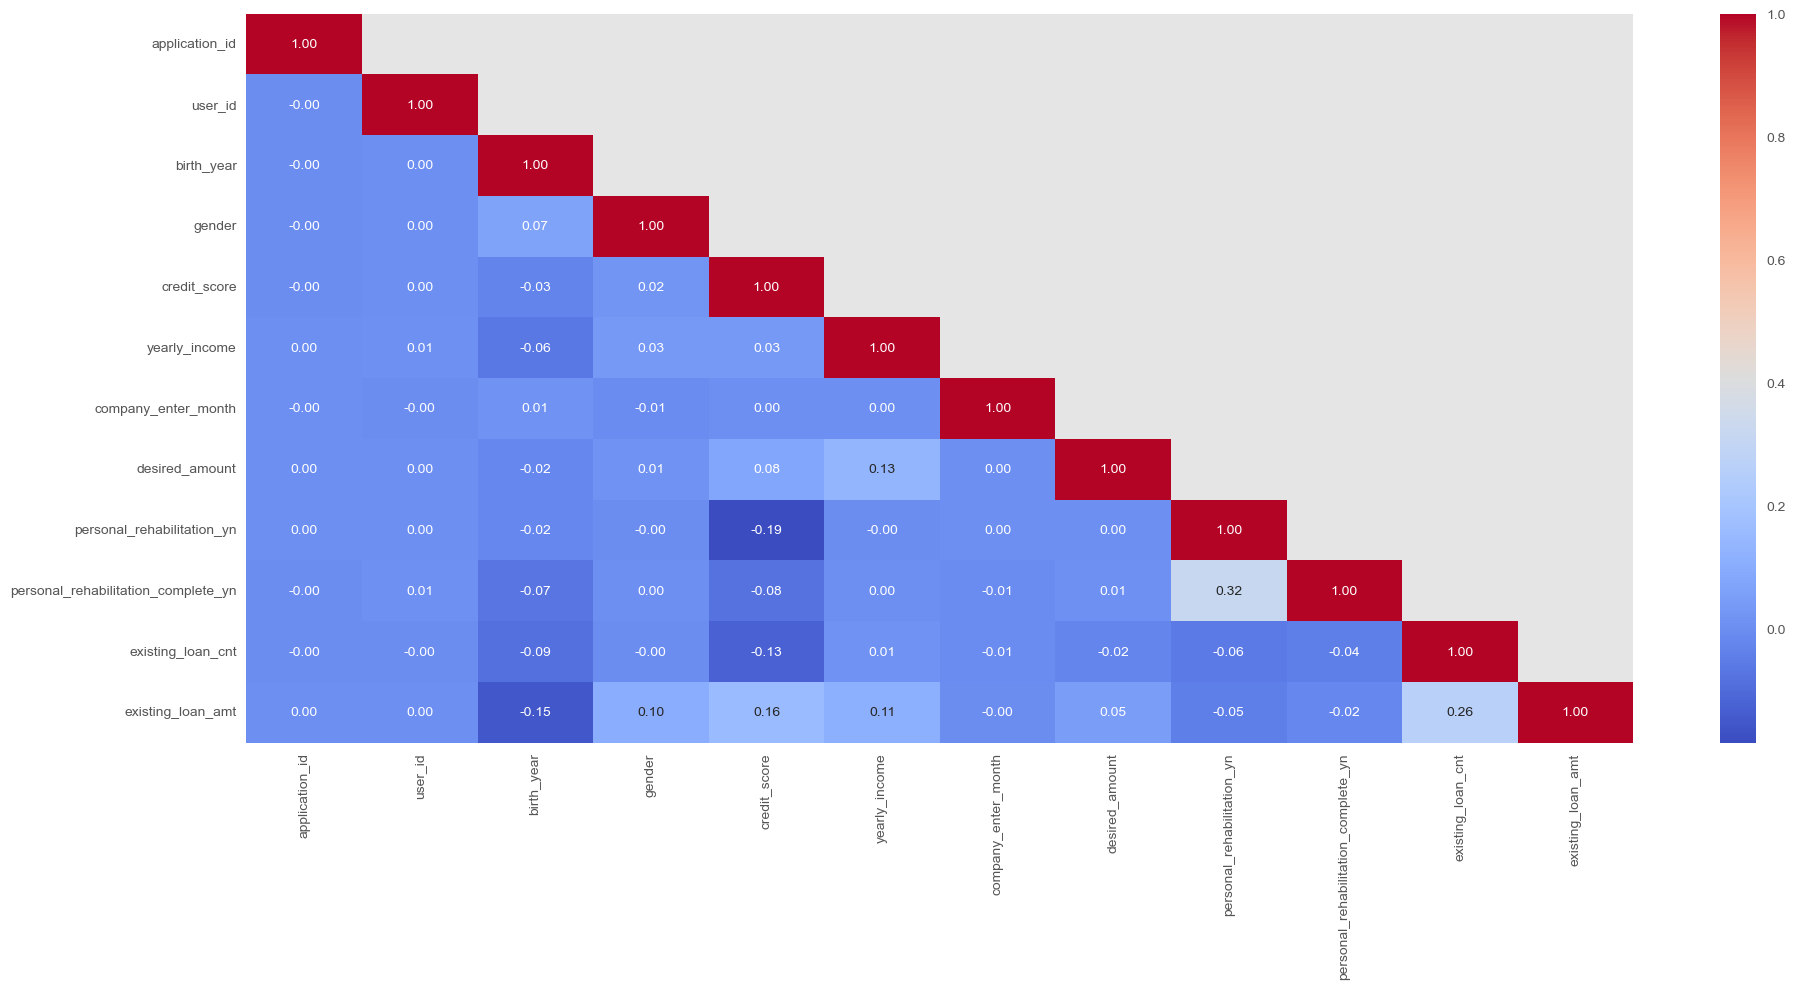

In [22]:
user_eda.check_corr()

결측치를 확인합니다...
👀칼럼 별 결측치 수
	 ❗ application_id : 0
	 ❗ user_id : 0
	 ❗ birth_year : 12961
	 ❗ gender : 12961
	 ❗ insert_time : 0
	 ❗ credit_score : 105115
	 ❗ yearly_income : 90
	 ❗ income_type : 85
	 ❗ company_enter_month : 171760
	 ❗ employment_type : 85
	 ❗ houseown_type : 85
	 ❗ desired_amount : 85
	 ❗ purpose : 85
	 ❗ personal_rehabilitation_yn : 587461
	 ❗ personal_rehabilitation_complete_yn : 1203354
	 ❗ existing_loan_cnt : 198556
	 ❗ existing_loan_amt : 313774
Done!!


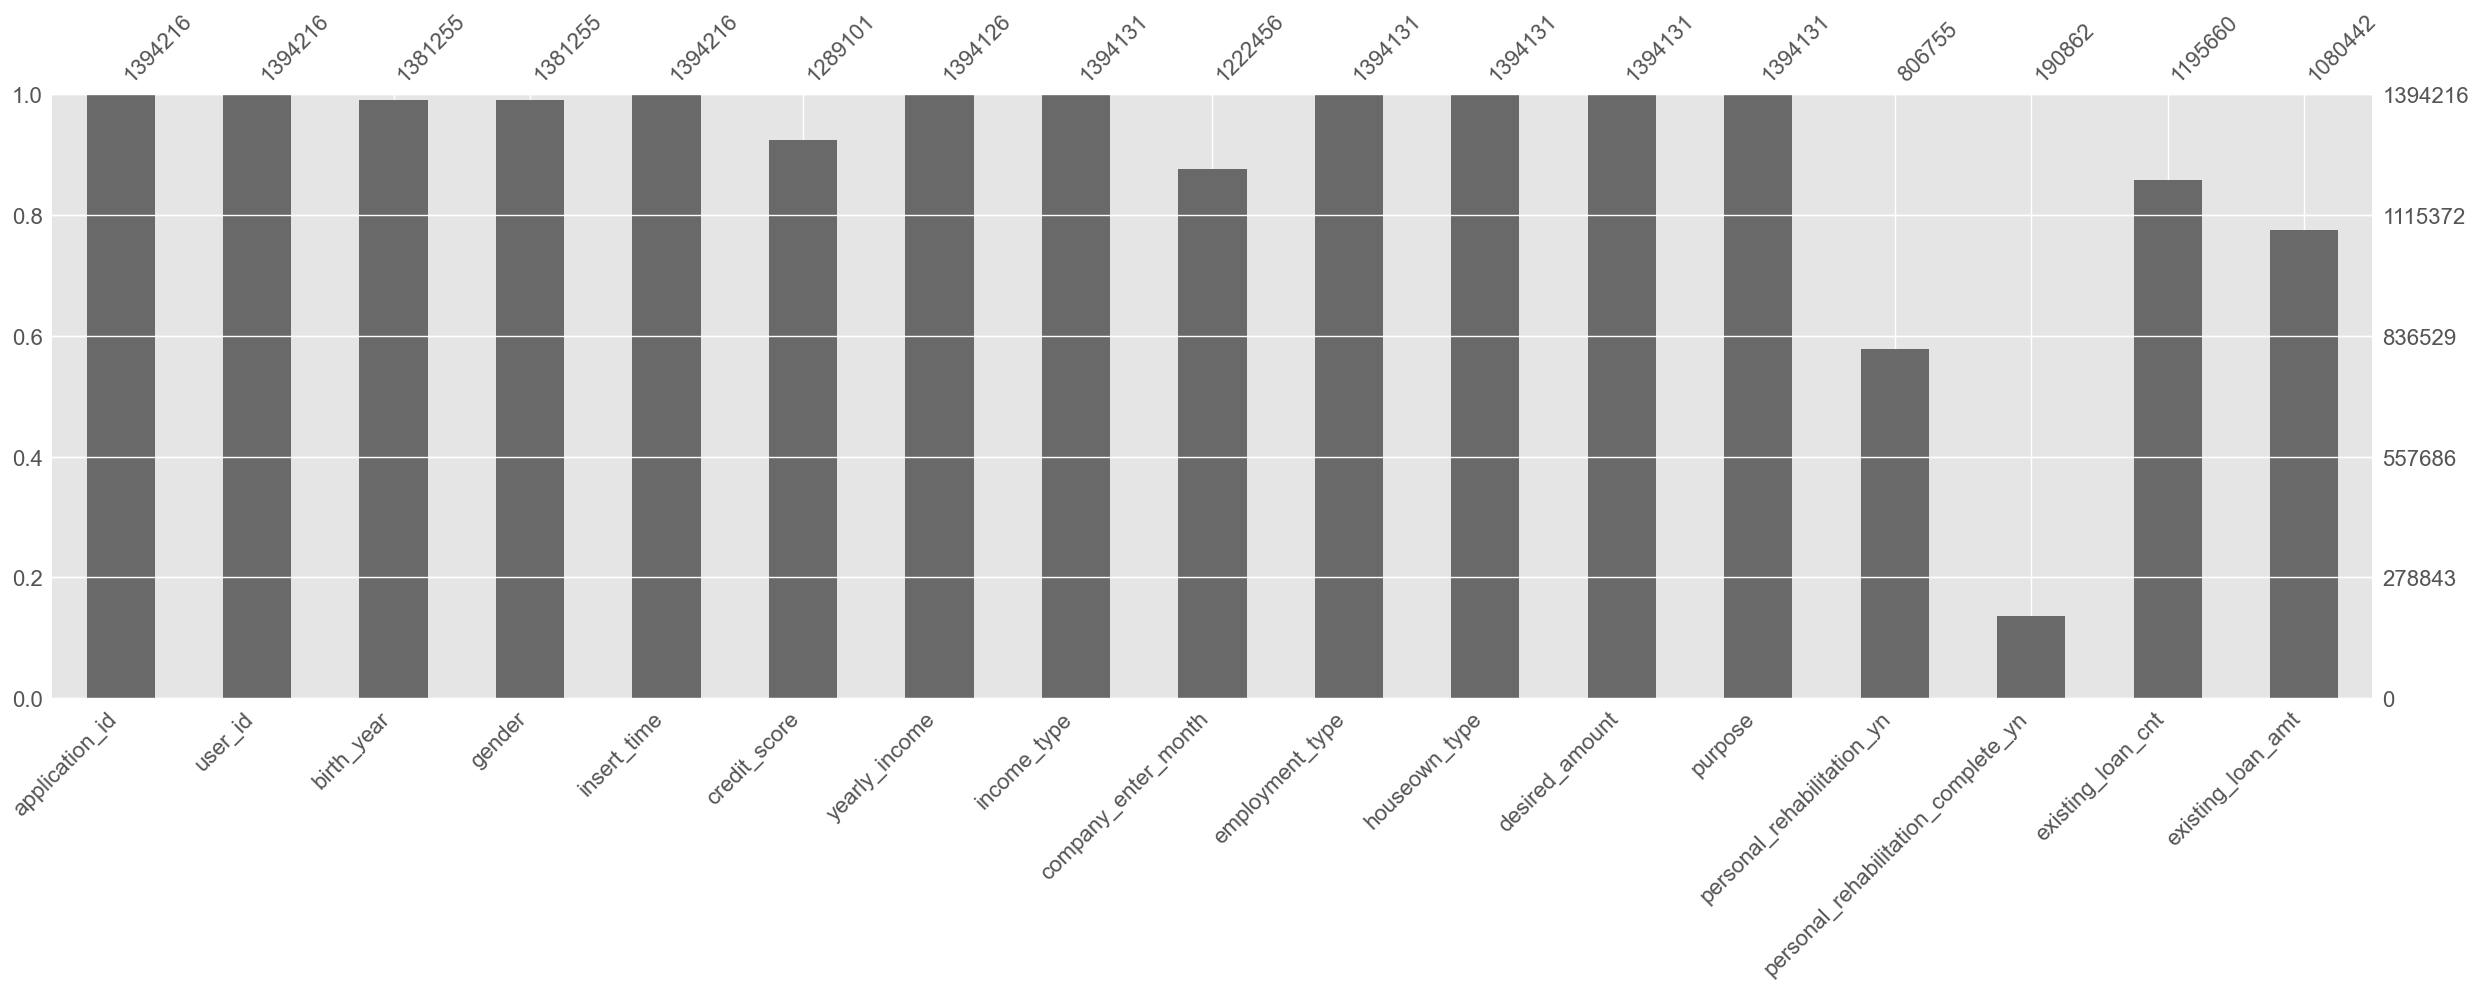

In [23]:
user_eda.check_missing_values()

이상치를 확인합니다...
파악된 연속형 변수
 ['application_id', 'user_id', 'birth_year', 'gender', 'credit_score', 'yearly_income', 'company_enter_month', 'desired_amount', 'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn', 'existing_loan_cnt', 'existing_loan_amt']
Done!!


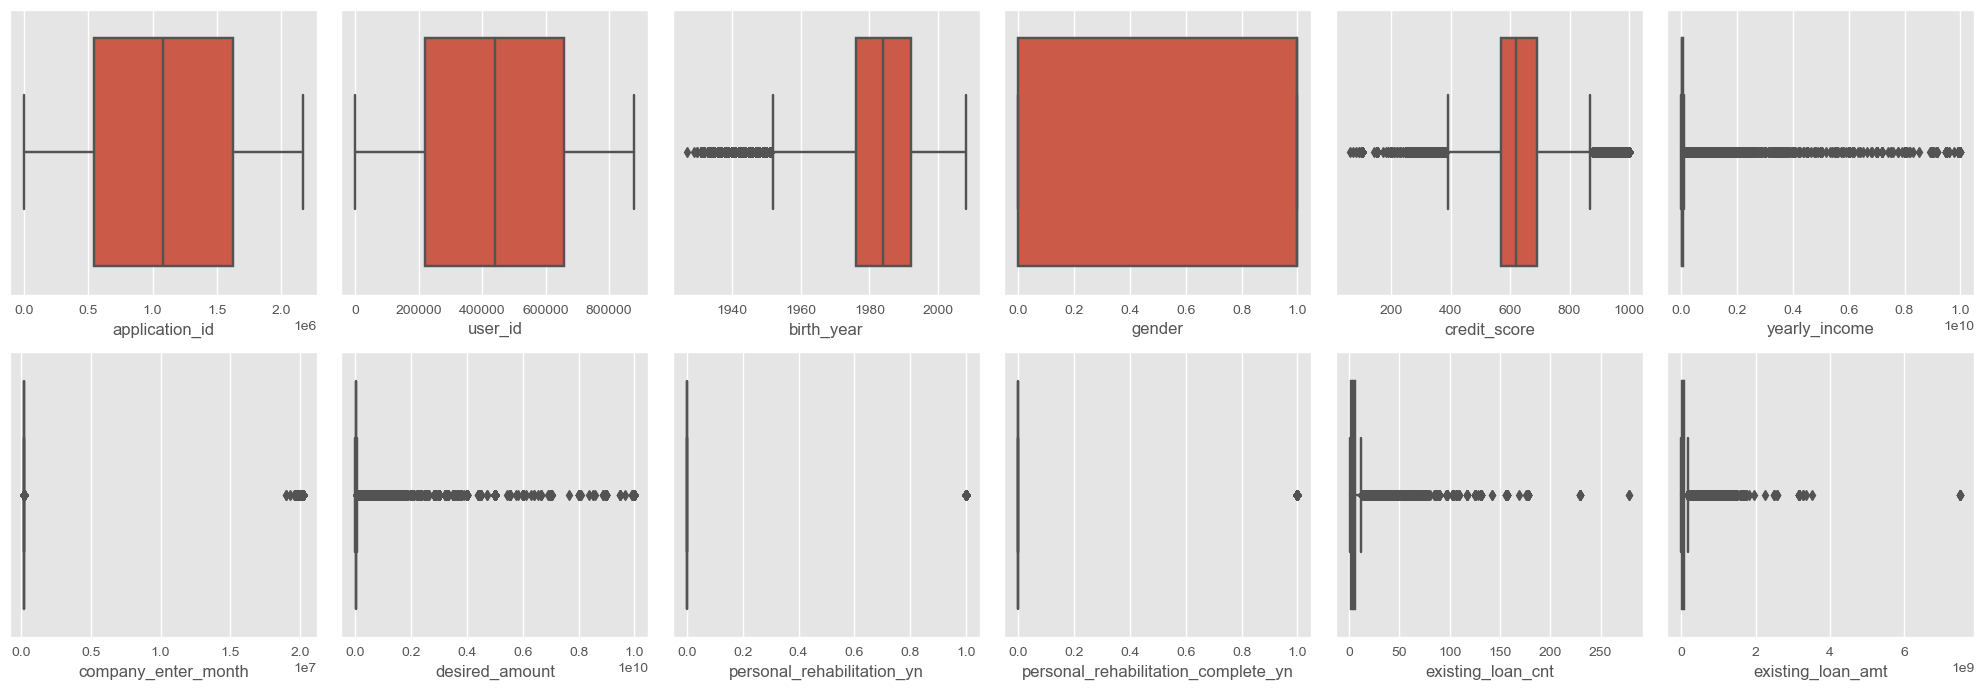

In [24]:
user_eda.check_outliers()

## Preprocess

In [6]:
prep_config = config_dict.get('Preprocessor')

# Loan preprocess
loan_preprocessor = Loan_Preprocessor(loan_df, prep_config)
prep_loan_df = loan_preprocessor.run(
    save_file_name='prep_loan.fth',
    save_mode=True
    )

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
결측치를 가지는 행 삭제 중...
✅ prep dataset saved at (data/prep/prep_loan.fth)


In [7]:
# Log preprocess
log_preprocessor = Log_Preprocessor(log_df, prep_config)
prep_log_df = log_preprocessor.run(
    save_file_name='prep_log.fth',
    save_mode=True
)

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
카테고리화 시키는 중...
시간축을 기준으로 정렬 중...
✅ prep dataset saved at (data/prep/prep_log.fth)


In [8]:
# User preprocess
user_preprocessor = User_Preprocessor(user_df, prep_config)
prep_user_df = user_preprocessor.run(
    save_file_name='prep_user.fth',
    save_mode=True
)

필요 없는 열 삭제 중...
datetime으로 바꾸는 중...
파생변수 생성 중...
카테고리화 시키는 중...
원핫인코딩 중...
순서형인코딩 중...
결측치를 가지는 행 삭제 중...
✅ prep dataset saved at (data/prep/prep_user.fth)


In [9]:
# cofix preprocess
cofix_preprocessor = Cofix_Preprocessor(cofix_df, prep_config)
prep_cofix_df = cofix_preprocessor.run(
    save_file_name='prep_cofix.fth',
    save_mode=True
)

대상기간 열 나누는 중...
datetime으로 바꾸는 중...
시간축을 기준으로 정렬 중...
COFIX 금리 열 이름 변경 중...
✅ prep dataset saved at (data/prep/prep_cofix.fth)


## Matcher

In [ ]:
matcher_config = config_dict.get('Matcher')

In [ ]:
matcher = Matcher(prep_user_df, prep_loan_df, prep_log_df, prep_cofix_df, matcher_config)

In [ ]:
train_valid_df, test_df = matcher.run(save_mode=True)

Loan과 Cofix 매칭중...
Loan_Cofix와 User를 merge중...
Train(Valid)과 Test로 나누는 중...
✅ matched dataset saved at (data/match/ml_train_valid.fth)
✅ matched dataset saved at (data/match/ml_test.fth)


## MICE

In [ ]:
# train
mice_train = mice(train_valid_df)
mice_train_df = mice_train.mice_1()

In [ ]:
# test
mice_test = mice(test_df)
mice_test_df = mice_test.mice_1()

In [ ]:
print(mice_train_df.shape)
print(mice_test_df.shape)

(10264386, 53)
(3255482, 53)


## Bank

In [ ]:
bank_info = Bank_info(mice_train_df)
final_train_df = bank_info.run()

## Resampling & Modeling

In [27]:
downsampled_df = down_sampling(mice_train_df) # input을 mice_train_df 하면 될 것 같아요
train_X, valid_X, train_Y, valid_Y = split_train_valid(downsampled_df)

Down Sampling 중...
Train과 Valid로 나누는 중...


In [28]:
print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape )

(887537, 52) (887537,) (221885, 52) (221885,)


In [76]:
NUM_DOWN_SAMPLING = 30

for sampling_idx in range(NUM_DOWN_SAMPLING):
    
    print(f'✅ Sampling #{sampling_idx}')
    
    # Resampling & split
    downsampled_df = down_sampling(mice_train_df) # input을 mice_train_df 하면 될 것 같아요
    train_X, train_Y, valid_X, valid_Y = split_train_valid(downsampled_df)
    
    # TODO: Modeling
    from src.models.rf_model import RF
    random_state = 42
    rf = RF(train_X, train_Y, valid_X, valid_Y, random_state)
    best_model = rf.grid_search()
    # TODO : Model results storing (e.g. wandb, Dataframe...?)
    # TODO : Voting (soft or hard voting)
    
    # del train_X, train_Y, valid_X, valid_Y # Free memory for long iterations
    # break

✅ Sampling0
Down Sampling 중...
Train과 Valid로 나누는 중...


# 여기 이후로 불필요한 셀 정리 부탁드립니다

## Modeling

In [88]:
# base line
# model_name : RF, XGB, LGBM, 

## 모델 서치 ##
# from src.models import XGB
# random_state = 42
# xgb = XGB(train_X, train_Y, val_X, val_Y, test_X, test_Y, random_state)
# best_model = xgb.grid_search()

## test 결과 확인 및 모델 해석 ##
# xgb.test_score(best_model)
# xgb.confusion_matrix(best_model)
# xgb.feature_importance(best_model)
# xgb.shap(best_model)


In [5]:
from src.models.rf_model import RF

In [1]:
from src.models.lgbm_model import LGBM

/Users/hanjun/opt/anaconda3/envs/bigcon/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.models.xgb_model import XGB

In [3]:
from src.models.catboost import CB

# Clustering

In [ ]:
def viz (df : pd.DataFrame, clus_col) :
    '''
    Input : 수치형 데이터 프레임, 군집화가 있는 Column 
    '''

    print('수치형 변수에 대해 시각화를 시작합니다.')
    from sklearn.decomposition import PCA

    con_cols = [i for i in df.columns if df[i].dtype != 'object' and i != 'user_id']

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    feature_df = df.loc[:, con_cols]
    
    scaler = MinMaxScaler()
    scaled_feature_df = scaler.fit_transform(feature_df)
    



    # feature_df.dropna(axis=0, inplace=True)
    feature_df.reset_index(drop=True, inplace=True)

    pca_2 = PCA(n_components=2)
    pca_2_transformed = pca_2.fit_transform(scaled_feature_df)

    pca_2_df = pd.DataFrame({'x_axis' : pca_2_transformed[:,0],
                            'y_axis' : pca_2_transformed[:,1],
                            'Cluster' : df[clus_col]})

    pca_3 = PCA(n_components=3)
    pca_3_transformed = pca_3.fit_transform(scaled_feature_df)
    pca_3_df = pd.DataFrame({'x_axis' : pca_3_transformed[:, 0],
                    'y_axis' : pca_3_transformed[:, 1],
                    'z_axis' : pca_3_transformed[:, 2],
                    'Cluster' : df[clus_col]})


    for i in range(len(pca_2_df['Cluster'].unique())) :
        marker_i = pca_2_df[pca_2_df['Cluster'] == i].index
        ax1.scatter(x = pca_2_df.loc[marker_i, 'x_axis'],
                    y = pca_2_df.loc[marker_i, 'y_axis'],
                    label = f'Cluster {i}',
                    alpha = 0.3)

    ax1.set_title('Clustering 2D Visualization')
    ax1.legend()

    for i in range(len(pca_3_df['Cluster'].unique())) :
        marker_i = pca_3_df[pca_3_df['Cluster'] == i].index
        ax2.scatter(xs = pca_3_df.loc[marker_i, 'x_axis'],
                    ys= pca_3_df.loc[marker_i, 'y_axis'],
                    zs =  pca_3_df.loc[marker_i, 'z_axis'],
                    label = f'Cluster {i}',
                    alpha = 0.3)

    ax2.set_title('Clustering 3D Visualization')
    ax2.legend()

    plt.show()


    '''
    Input : 수치형 데이터 프레임, 군집화가 있는 Column 
    '''

    print('수치형 변수와 특정 변수에 대해 시각화를 시작합니다.')
    from sklearn.decomposition import PCA

    con_cols = [i for i in df.columns if df[i].dtype != 'object']

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    feature_df = df.loc[:, con_cols]
    
    scaler = MinMaxScaler()
    scaled_feature_df = scaler.fit_transform(feature_df)
    



    # feature_df.dropna(axis=0, inplace=True)
    feature_df.reset_index(drop=True, inplace=True)

    pca_2 = PCA(n_components=2)
    pca_2_transformed = pca_2.fit_transform(scaled_feature_df)

    pca_2_df = pd.DataFrame({'x_axis' : pca_2_transformed[:,0],
                            'y_axis' : pca_2_transformed[:,1],
                            'Cluster' : df[clus_col],
                            something : df[something]})

    pca_3 = PCA(n_components=3)
    pca_3_transformed = pca_3.fit_transform(scaled_feature_df)
    pca_3_df = pd.DataFrame({'x_axis' : pca_3_transformed[:, 0],
                    'y_axis' : pca_3_transformed[:, 1],
                    'z_axis' : pca_3_transformed[:, 2],
                    'Cluster' : df[clus_col],
                    something : df[something]})


    for i in range(len(pca_2_df['Cluster'].unique())) :
        marker_i = pca_2_df[pca_2_df['Cluster'] == i].index
        ax1.scatter(x = pca_2_df.loc[marker_i, 'x_axis'],
                    y = pca_2_df.loc[marker_i, 'y_axis'],
                    label = f'Cluster {i}',
                    alpha = 0.3)

    for i in pca_2_df[something].unique() :
        marker_i = pca_2_df[pca_2_df[something] == i].index
        ax1.scatter(x = pca_2_df.loc[marker_i, 'x_axis'],
                    y = pca_2_df.loc[marker_i, 'y_axis'],
                    label = f'{something}_{i}',
                    alpha = 0.3)

    ax1.set_title('Clustering 2D Visualization')
    ax1.legend()

    for i in pca_3_df['Cluster'].unique() :
        marker_i = pca_3_df[pca_3_df['Cluster'] == i].index
        ax2.scatter(xs = pca_3_df.loc[marker_i, 'x_axis'],
                    ys= pca_3_df.loc[marker_i, 'y_axis'],
                    zs =  pca_3_df.loc[marker_i, 'z_axis'],
                    label = f'Cluster {i}',
                    alpha = 0.5)

    for i in pca_3_df[something].unique() :
        marker_i = pca_3_df[pca_3_df[something] == i].index
        ax2.scatter(xs = pca_3_df.loc[marker_i, 'x_axis'],
                    ys= pca_3_df.loc[marker_i, 'y_axis'],
                    zs =  pca_3_df.loc[marker_i, 'z_axis'],
                    label = f'{something}_{i}',
                    alpha = 0.5)

    ax2.set_title('Clustering 3D Visualization')
    ax2.legend()

    plt.show()

## General Clustering

In [ ]:
'''
Example
1. 그냥 전처리 후의 시각화
clus = ClusteringPreprocessor(df)
clus.run()

2. Extracction 이후의 시각화
clus = ClusteringPreprocessor(df, extraction=True)
clus.run()

3. Selection 이후의 시각화
clus = ClusteringPReprocesor(df, selection=True)
clus.run()
'''

전처리 시작...
결측치 제거 전 :  3025600
결측치 제거 후 :  0


Progress bar:   0%|          | 0/36 [00:00<?, ?it/s]

Scaling 완료
총 4개의 DataFrame이 나왔습니다. shape : (118255, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118255 entries, 0 to 118254
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   gender_0.0                               118255 non-null  float64
 1   gender_1.0                               118255 non-null  float64
 2   income_type_EARNEDINCOME                 118255 non-null  float64
 3   income_type_EARNEDINCOME2                118255 non-null  float64
 4   income_type_FREELANCER                   118255 non-null  float64
 5   income_type_PRACTITIONER                 118255 non-null  float64
 6   income_type_PRIVATEBUSINESS              118255 non-null  float64
 7   employment_type_계약직                      118255 non-null  float64
 8   employment_type_기타                       118255 non-null  float64
 9   employment_type_일용직                      118255

Progress bar:   0%|          | 0/36 [00:00<?, ?it/s]

Selected Columns
 Index(['age', 'yearly_income', 'credit_score', 'existing_loan_amt',
       'existing_loan_percent', 'income_per_credit', 'desired_amount',
       'existing_loan_cnt', 'service_year', 'personal_rehabilitation_yn_0.0'],
      dtype='object')


Progress bar:   0%|          | 0/36 [00:00<?, ?it/s]

Selected Columns
 Index(['age', 'yearly_income', 'credit_score', 'existing_loan_amt',
       'existing_loan_percent', 'income_per_credit', 'desired_amount',
       'existing_loan_cnt', 'service_year', 'personal_rehabilitation_yn_0.0'],
      dtype='object')


Progress bar:   0%|          | 0/36 [00:00<?, ?it/s]

Selected Columns
 Index(['age', 'yearly_income', 'credit_score', 'existing_loan_amt',
       'existing_loan_percent', 'income_per_credit', 'desired_amount',
       'existing_loan_cnt', 'service_year', 'personal_rehabilitation_yn_0.0'],
      dtype='object')


Progress bar: 100%|██████████| 36/36 [00:19<00:00,  1.85it/s]


Selected Columns
 Index(['existing_loan_amt', 'income_per_credit', 'age', 'credit_score',
       'existing_loan_percent', 'desired_amount', 'existing_loan_cnt',
       'service_year', 'gender_0.0', 'income_type_PRIVATEBUSINESS'],
      dtype='object')
시각화를 시작합니다...
현재 Scaler :  StandardScaler


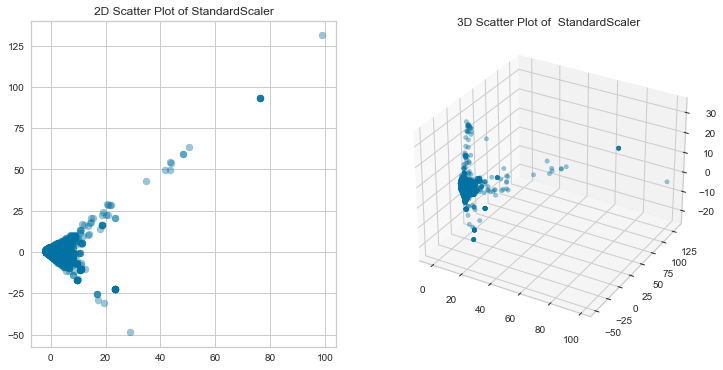

현재 Scaler :  MinMaxScaler


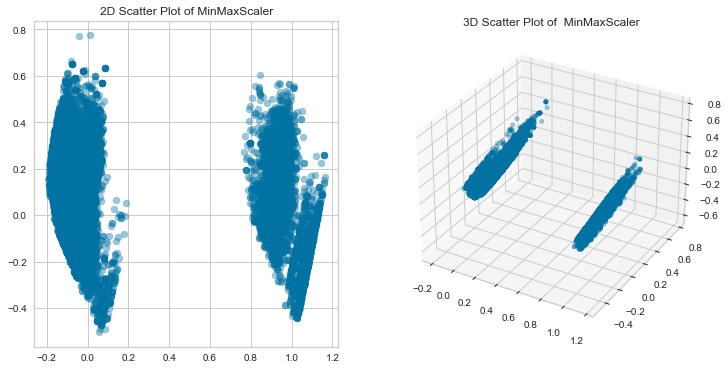

현재 Scaler :  RobustScaler


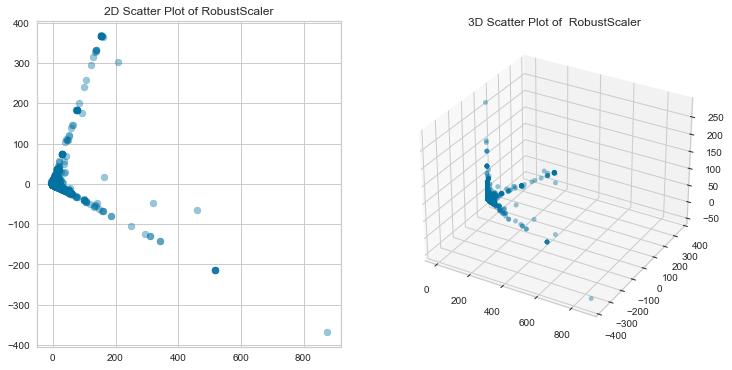

현재 Scaler :  PowerTransformer


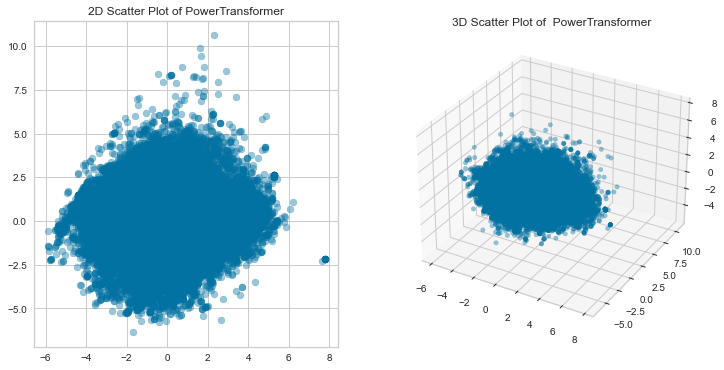

Selection 결과 DF List를 반환합니다.


([             age  yearly_income  credit_score  existing_loan_amt  \
  0      -1.322321      -0.052633      0.076047          -0.539754   
  1      -1.322321      -0.152975     -0.703244          -0.504317   
  2       1.143561       0.210762      0.153976           0.003607   
  3      -0.089380      -0.353657     -0.469457          -0.457068   
  4       1.020267       0.260933     -0.781173           0.405222   
  ...          ...            ...           ...                ...   
  118250 -0.089380      -0.479084     -0.235669          -0.657876   
  118251  0.403797      -0.190603     -0.001882          -0.622439   
  118252 -0.582557      -0.002463     -0.235669           0.133541   
  118253 -0.089380      -0.077719     -0.157740          -0.185388   
  118254 -0.952439       0.047708      0.231905          -0.468880   
  
          existing_loan_percent  income_per_credit  desired_amount  \
  0                   -0.365583          -0.081740       -0.139417   
  1              

In [11]:
from src.clustering import Clustering
from src.clustering_preprocessor import ClusteringPreprocessor

df = pd.read_csv('./data/user_spec.csv')

clus = ClusteringPreprocessor(df, selection=True)
selection_list, fitted_scaler, ori_df = clus.run()
selection_list, fitted_scaler, ori_df


K-Means로 군집화 수행 중...


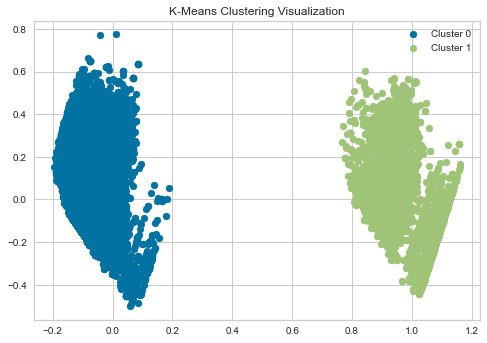

Gaussian Mixture로 군집화 중...


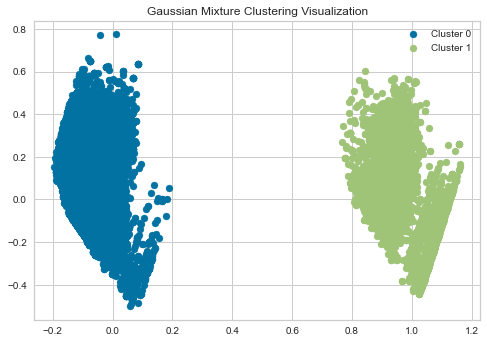

,age,yearly_income,credit_score,existing_loan_amt,existing_loan_percent,income_per_credit,desired_amount,existing_loan_cnt,service_year,personal_rehabilitation_yn_0.0,KM,GM
0,0.049180,0.003821,0.588889,0.005057,0.000997,0.001726,0.0005,0.000000,0.019231,1.0,0,0
1,0.049180,0.002948,0.477778,0.006005,0.001521,0.001593,0.0003,0.017544,0.000000,1.0,0,0
2,0.377049,0.006114,0.600000,0.019595,0.002439,0.002708,0.0025,0.013158,0.000000,1.0,0,0
3,0.213115,0.001201,0.511111,0.007269,0.004297,0.000627,0.0003,0.039474,0.019231,1.0,0,0
4,0.360656,0.006551,0.466667,0.030341,0.003529,0.003577,0.0005,0.026316,0.057692,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
118250,0.213115,0.000109,0.544444,0.001896,0.006726,0.000072,0.0050,0.004386,0.096154,0.0,1,1
118251,0.278689,0.002620,0.577778,0.002845,0.000807,0.001208,0.0030,0.008772,0.038462,1.0,0,0
118252,0.147541,0.004258,0.544444,0.023072,0.004092,0.002053,0.0003,0.030702,0.019231,1.0,0,0
118253,0.213115,0.003603,0.555556,0.014539,0.003034,0.001711,0.0001,0.017544,0.019231,1.0,0,0


In [12]:
mm_df = selection_list[1]

clus = Clustering(mm_df, scaled=True, num_clus=2)
fin_df = clus.run()
fin_df

In [13]:
from sklearn.metrics import silhouette_score

score_km = silhouette_score(mm_df, fin_df['KM'])
score_gm = silhouette_score(mm_df, fin_df['GM'])

print(f'{score_km:.2f}')
print(f'{score_gm:.2f}')

0.78
0.78


In [14]:
clus_0 = fin_df[fin_df['KM'] == 0]
clus_1 = fin_df[fin_df['KM'] == 1]

In [ ]:
clus_0.describe()

,age,yearly_income,credit_score,existing_loan_amt,existing_loan_percent,income_per_credit,desired_amount,existing_loan_cnt,service_year,personal_rehabilitation_yn_0.0,KM
count,111301.000000,111301.000000,111301.000000,111301.000000,111301.000000,111301.000000,111301.000000,111301.000000,111301.000000,111301.0,111301.0
mean,0.216976,0.004280,0.590887,0.020001,0.004101,0.001947,0.002616,0.016868,0.050438,1.0,0.0
std,0.126783,0.008511,0.121075,0.027302,0.008423,0.003189,0.014201,0.020677,0.071727,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
25%,0.131148,0.002730,0.511111,0.006005,0.001401,0.001249,0.000500,0.004386,0.000000,1.0,0.0
50%,0.196721,0.003385,0.566667,0.012642,0.002803,0.001616,0.001000,0.013158,0.019231,1.0,0.0
75%,0.295082,0.004695,0.644444,0.022756,0.004634,0.002149,0.003000,0.021930,0.057692,1.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.327706,1.000000,1.000000,0.903846,1.0,0.0


In [ ]:
clus_1.describe()

,age,yearly_income,credit_score,existing_loan_amt,existing_loan_percent,income_per_credit,desired_amount,existing_loan_cnt,service_year,personal_rehabilitation_yn_0.0,KM
count,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.0,6954.0
mean,0.353411,0.004275,0.372518,0.011463,0.003667,0.005209,0.002884,0.009085,0.057988,0.0,1.0
std,0.160789,0.011364,0.257304,0.013259,0.008408,0.016173,0.027380,0.011777,0.086873,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.0,1.0
25%,0.229508,0.002620,0.000000,0.003477,0.000817,0.001415,0.000300,0.000000,0.019231,0.0,1.0
50%,0.344262,0.003385,0.477778,0.008217,0.001868,0.002172,0.001000,0.004386,0.019231,0.0,1.0
75%,0.459016,0.004586,0.566667,0.014855,0.003408,0.006688,0.002000,0.013158,0.076923,0.0,1.0
max,0.934426,0.491211,1.000000,0.336283,0.230194,1.000000,1.000000,0.254386,1.000000,0.0,1.0


In [20]:
import pingouin as pg

cols = [i for i in clus_0.columns if i != 'KM' and i !='GM']

values = []

for i in cols :

    ttest = pg.ttest(clus_0[i], clus_1[i], correction='auto')

    values.append(ttest['p-val'].values[0])

ttest_df = pd.DataFrame(values, columns=['P-Value'], index = cols)

TF = [True if i < 0.05 else False for i in ttest_df['P-Value']]

ttest_df['유의미한 차이'] = TF
ttest_df

# ''' 
# 결과 : 연소득과 대출희망금액을 제외한 모든 Selected Column에서 유의미한 차이를 보이는 것으로 확인됨
# '''


,P-Value,유의미한 차이
age,0.000000e+00,True
yearly_income,9.739454e-01,False
credit_score,0.000000e+00,True
existing_loan_amt,0.000000e+00,True
existing_loan_percent,3.010648e-05,True
income_per_credit,4.009306e-62,True
desired_amount,4.192735e-01,False
existing_loan_cnt,0.000000e+00,True
service_year,1.378010e-12,True
personal_rehabilitation_yn_0.0,0.000000e+00,True


In [23]:
scaler = fitted_scaler[1] ## 원래 학습되어 있던 MinMax를 가져옴

clus_0_recol = clus_0[['age', 'credit_score', 'yearly_income','service_year',
                                'desired_amount', 'existing_loan_cnt', 'existing_loan_amt',
                                'income_per_credit', 'existing_loan_percent']]

clus_0_ori = scaler.inverse_transform(clus_0_recol)
                                
clus_0_ori_df = pd.DataFrame(clus_0_ori, columns = clus_0_recol.columns)

clus_0_ori_df['personal_rehabilitation_yn_0.0'] = clus_0['personal_rehabilitation_yn_0.0']
clus_0_ori_df

,age,credit_score,yearly_income,service_year,desired_amount,existing_loan_cnt,existing_loan_amt,income_per_credit,existing_loan_percent,personal_rehabilitation_yn_0.0
0,22.0,630.0,36000000.0,1.0,5000000.0,1.0,16000000.0,57142.857143,0.444444,1.0
1,22.0,530.0,28000000.0,0.0,3000000.0,5.0,19000000.0,52830.188679,0.678571,1.0
2,42.0,640.0,57000000.0,0.0,25000000.0,4.0,62000000.0,89062.500000,1.087719,1.0
3,32.0,560.0,12000000.0,1.0,3000000.0,10.0,23000000.0,21428.571429,1.916667,1.0
4,41.0,520.0,61000000.0,3.0,5000000.0,7.0,96000000.0,117307.692308,1.573770,1.0
...,...,...,...,...,...,...,...,...,...,...
111296,29.0,540.0,36000000.0,1.0,3000000.0,4.0,60000000.0,66666.666667,1.666667,1.0
111297,36.0,620.0,25000000.0,2.0,30000000.0,3.0,9000000.0,40322.580645,0.360000,1.0
111298,28.0,590.0,40000000.0,1.0,3000000.0,8.0,73000000.0,67796.610169,1.825000,1.0
111299,32.0,600.0,34000000.0,1.0,1000000.0,5.0,46000000.0,56666.666667,1.352941,1.0


In [27]:
scaler = fitted_scaler[1] ## 원래 학습되어 있던 MinMax를 가져옴

clus_1_recol = clus_1[['age', 'credit_score', 'yearly_income','service_year',
                                'desired_amount', 'existing_loan_cnt', 'existing_loan_amt',
                                'income_per_credit', 'existing_loan_percent']]

clus_1_ori = scaler.inverse_transform(clus_1_recol)
                                
clus_1_ori_df = pd.DataFrame(clus_1_ori, columns = clus_1_recol.columns)

clus_1_ori_df['personal_rehabilitation_yn_0.0'] = clus_1['personal_rehabilitation_yn_0.0']
clus_1_ori_df

,age,credit_score,yearly_income,service_year,desired_amount,existing_loan_cnt,existing_loan_amt,income_per_credit,existing_loan_percent,personal_rehabilitation_yn_0.0
0,46.0,100.0,50000000.0,8.0,5000000.0,1.0,25000000.0,500000.000000,0.500000,NaN
1,46.0,540.0,40000000.0,3.0,15000000.0,2.0,64000000.0,74074.074074,1.600000,NaN
2,36.0,250.0,30000000.0,2.0,1000000.0,5.0,37000000.0,120000.000000,1.233333,NaN
3,46.0,600.0,35000000.0,0.0,3000000.0,2.0,9000000.0,58333.333333,0.257143,NaN
4,32.0,580.0,55000000.0,6.0,5000000.0,3.0,67000000.0,94827.586207,1.218182,NaN
...,...,...,...,...,...,...,...,...,...,...
6949,39.0,710.0,3000000.0,0.0,30000000.0,6.0,70000000.0,4225.352113,23.333333,NaN
6950,39.0,710.0,3000000.0,0.0,30000000.0,6.0,70000000.0,4225.352113,23.333333,NaN
6951,34.0,470.0,33000000.0,4.0,10000000.0,2.0,9000000.0,70212.765957,0.272727,NaN
6952,58.0,100.0,50000000.0,2.0,15000000.0,3.0,21000000.0,500000.000000,0.420000,NaN


In [33]:
## 차이가 유의미 했던 변수들
significant_cols = ['age', 'credit_score', 'existing_loan_amt', 
'existing_loan_percent', 'income_per_credit','existing_loan_cnt', 
'service_year', 'personal_rehabilitation_yn_0.0']

clus_0_ori_sig = clus_0_ori_df[significant_cols]
clus_1_ori_sig = clus_1_ori_df[significant_cols]


clus_0_means = [clus_0_ori_sig[i].mean() for i in significant_cols]
clus_1_means = [clus_1_ori_sig[i].mean() for i in significant_cols]

significant_df = pd.DataFrame()

significant_df['CLUSTER 0'] = clus_0_means
significant_df['CLUSTER 1'] = clus_1_means


pd.options.display.float_format = '{:.5f}'.format

significant_df.index = significant_cols
significant_df

,CLUSTER 0,CLUSTER 1
age,32.23552,40.55810
credit_score,631.79864,435.26603
existing_loan_amt,63283106.17155,36270204.19902
existing_loan_percent,1.82912,1.63557
income_per_credit,64333.13440,170347.86638
existing_loan_cnt,4.84581,3.07147
service_year,2.62276,3.01539
personal_rehabilitation_yn_0.0,1.00000,0.00000


In [34]:
values = []

for i in significant_cols :

    ttest = pg.ttest(clus_0_ori_sig[i], clus_1_ori_sig[i], correction='auto')

    values.append(ttest['p-val'].values[0])

ttest_df_ori_ver = pd.DataFrame(values, columns=['P-Value'], index = significant_cols)

TF = [True if i < 0.05 else False for i in ttest_df_ori_ver['P-Value']]

ttest_df_ori_ver['유의미한 차이'] = TF
ttest_df_ori_ver

,P-Value,유의미한 차이
age,0.00000,True
credit_score,0.00000,True
existing_loan_amt,0.00000,True
existing_loan_percent,0.00003,True
income_per_credit,0.00000,True
existing_loan_cnt,0.00000,True
service_year,0.00000,True
personal_rehabilitation_yn_0.0,0.00000,True


## K-Prototype Clustering

In [ ]:
df = pd.read_csv('./data/user_spec.csv')

kproto = KPrototype(df, n_clus = 3)

kproto_clus_df, group_by = kproto.run()
kproto_clus_df

In [ ]:
viz(kproto_clus_df, 'KProto')

In [ ]:
group_by

## Inference

## Evaluation